In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
!pip install shap
import shap

import matplotlib.pyplot as plt


# data loading and ensuring format

In [ ]:

# 1. Load the expression matrix
expression_matrix = pd.read_csv("/content/filtered_expression_matrixX.csv", index_col=0)

# 2. Transpose the expression matrix to ensure features are columns and samples are rows
expression_matrix = expression_matrix.T
#print(expression_matrix.head(1))
# 3. Load the labels
labels = pd.read_csv("/content/labels.csv",header=0)
print(labels.head(3))

# Standardize the format in expression_matrix
expression_matrix.index = expression_matrix.index.str.replace('.', '-')
#print(expression_matrix.index[:5])



                       SampleID  Label
0  TCGA-FV-A3I0-01A-11R-A22L-07      1
1  TCGA-DD-A3A6-11A-11R-A22L-07      0
2  TCGA-DD-A3A6-01A-11R-A22L-07      1


In [ ]:
#to ensure that all my samples have label and they are aligned together (paired)

labels = labels.set_index('SampleID')

# Find common IDs between the two datasets (itersection will be the sampleid column)
common_ids = set(expression_matrix.index).intersection(set(labels.index))
# Convert the set of common IDs to a list(now i have list of samples id)
common_ids = list(common_ids)

# Filter expression_matrix and labels to only include common IDs( to avoid having sample without label)
expression_matrix = expression_matrix.loc[common_ids]
labels = labels.loc[common_ids]

# Check the result
print("Filtered Expression Matrix Shape:", expression_matrix.shape)
print("Filtered Labels Shape:", labels.shape)

Filtered Expression Matrix Shape: (424, 3130)
Filtered Labels Shape: (424, 1)


#Catboost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import shap

X = expression_matrix
y = labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_seed=42
)

# Train the model
catboost_model.fit(X_train, y_train)

#  SHAP values
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_train)

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values).mean(axis=0)

#  DataFrame for SHAP feature importance
shap_df = pd.DataFrame({
    'feature': X_train.columns,
    'shap_value': shap_importance
}).sort_values(by='shap_value', ascending=False)

#  top features based on SHAP values
num_features_to_select = 50
top_features = shap_df.head(num_features_to_select)['feature']

# Filter the training and test datasets with selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Compute the correlation matrix of selected features
correlation_matrix = X_train_selected.corr().abs()

#  threshold for correlation
correlation_threshold = 0.85

# Identify and remove redundant features
redundant_features = set()
columns = correlation_matrix.columns

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if correlation_matrix.iloc[i, j] > correlation_threshold:
            redundant_features.add(columns[j])

# Drop redundant features
X_train_selected_cleaned = X_train_selected.drop(columns=redundant_features)
X_test_selected_cleaned = X_test_selected.drop(columns=redundant_features)

print(f"Selected {X_train_selected_cleaned.shape[1]} features after redundancy removal.")
print(f"Features removed due to high correlation: {redundant_features}")

# Define the parameter grid for GridSearchCV
param_grid = {
    'depth': [4, 6, 8, 10],
    'iterations': [100, 200, 300, 500, 800,1000],
    'learning_rate': [0.001, 0.0005,0.01, 0.05, 0.1, 0.2]
}

# Integrate GridSearchCV with CatBoostClassifier
grid_search = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_seed=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV on the reduced feature set
grid_search.fit(X_train_selected_cleaned, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test_selected_cleaned)

# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Selected {X_train_selected_cleaned.shape[1]} features after redundancy removal.")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Test Accuracy after GridSearchCV: {accuracy * 100:.2f}%")


Selected 44 features after redundancy removal.
Features removed due to high correlation: {'ENSG00000104938.18', 'ENSG00000174059.17', 'ENSG00000160339.16', 'ENSG00000165682.14', 'ENSG00000263761.3', 'ENSG00000130812.10'}
Selected 44 features after redundancy removal.
Best Hyperparameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}
Test Accuracy after GridSearchCV: 99.22%


In [ ]:
# Save selected features to a CSV file
selected_features_file = "selected_features.csv"
pd.DataFrame({'Selected Features': X_train_selected_cleaned.columns}).to_csv(selected_features_file, index=False)

print(f"Selected features saved to {selected_features_file}.")



Selected features saved to selected_features.csv.


# validation

In [ ]:
#using cross validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores) * 100:.2f}%")


Cross-Validation Scores: [0.98529412 0.98529412 0.97058824 1.         1.        ]
Mean CV Accuracy: 98.82%


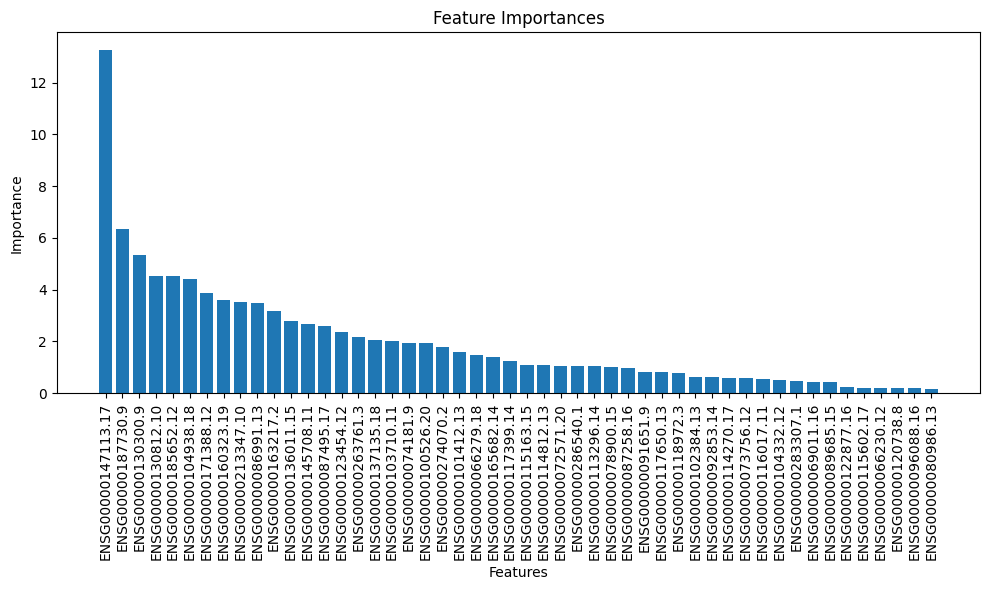

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert selected_features to a NumPy array for indexing
selected_features_array = np.array(selected_features)

# Sort indices based on feature importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), feature_importances[sorted_idx])
plt.xticks(range(len(selected_features)), selected_features_array[sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
#test  overfitting
train_accuracy = accuracy_score(y_train, best_model.predict(X_train_selected))
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Accuracy: 100.00%
Test Accuracy: 98.82%


In [ ]:
# Save selected features
pd.Series(selected_features).to_csv("selected_features.csv", index=False)

# Save the trained model
best_model.save_model("final_catboost_model.json")
print("Selected features and model saved!")


Selected features and model saved!


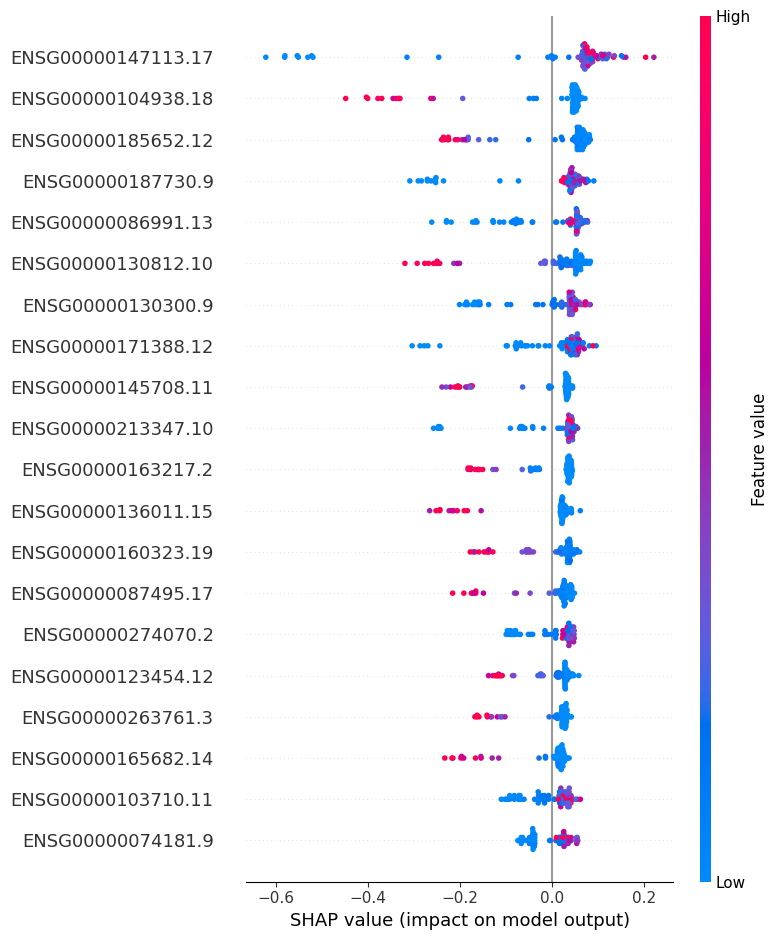

In [ ]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_selected)
shap.summary_plot(shap_values, X_test_selected)


In [ ]:
from gprofiler import GProfiler

# Initialize GProfiler
gp = GProfiler(return_dataframe=True)

# Prepare selected features
selected_features = [gene.split('.')[0] for gene in selected_features]  # Strip version numbers

# Perform enrichment analysis
enriched_terms = gp.profile(organism='hsapiens', query=selected_features)

#  results
if enriched_terms.empty:
    print("No enriched terms found. Verify input gene identifiers.")
else:
    print(enriched_terms.head())


  source      native                                               name  \
0  GO:BP  GO:0042127        regulation of cell population proliferation   
1  GO:BP  GO:0008284  positive regulation of cell population prolife...   
2  GO:BP  GO:0008283                      cell population proliferation   
3  GO:BP  GO:0033002                          muscle cell proliferation   
4  GO:CC  GO:0000779           condensed chromosome, centromeric region   

    p_value  significant                                        description  \
0  0.000009         True  "Any process that modulates the frequency, rat...   
1  0.000017         True  "Any process that activates or increases the r...   
2  0.000021         True  "The multiplication or reproduction of cells, ...   
3  0.000557         True  "The expansion of a muscle cell population by ...   
4  0.000642         True  "The region of a condensed chromosome that inc...   

   term_size  query_size  intersection_size  effective_domain_size  precis

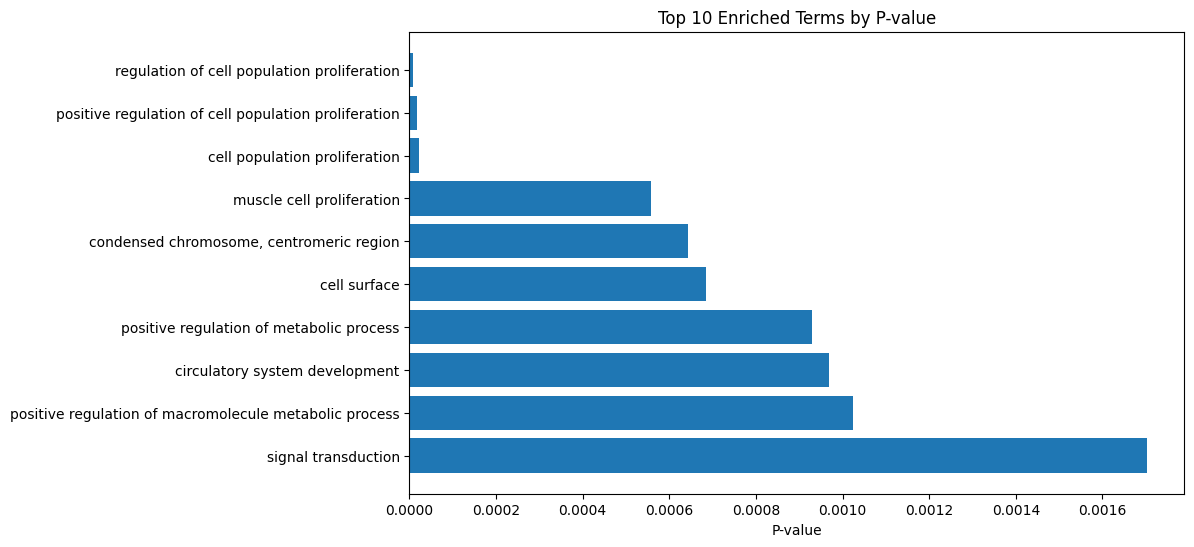

In [ ]:
import matplotlib.pyplot as plt

# Sort the enriched terms by p-value
enriched_terms_sorted = enriched_terms.sort_values(by="p_value")
plt.figure(figsize=(10, 6))
plt.barh(enriched_terms_sorted['name'][:10], enriched_terms_sorted['p_value'][:10])
plt.xlabel("P-value")
plt.title("Top 10 Enriched Terms by P-value")
plt.gca().invert_yaxis()  # To show the highest p-value on top
plt.show()
